**Prediksi Quantity Menggunakan 7 Model Regresi**

         P/N  Period  Quantity  MA_Prediction  Smoothed_Weighted_Prediction  \
0   205401.0       1       0.0       0.000000                      0.000000   
1   205401.0       2     144.0      72.000000                     43.200000   
2   205401.0       3      49.0      64.333333                     44.940000   
3   205401.0       4       1.0      48.500000                     31.758000   
4   205401.0       5      66.0      52.000000                     42.030600   
5   205401.0       6       0.0      43.333333                     29.421420   
6   205401.0       7       2.0      37.428571                     21.194994   
7   205401.0       8      98.0      45.000000                     44.236496   
8   205401.0       9       1.0      40.111111                     31.265547   
9   205401.0      10      96.0      45.700000                     50.685883   
10  205401.0      11     120.0      52.454545                     71.480118   
11  205401.0      12       0.0      48.083333       

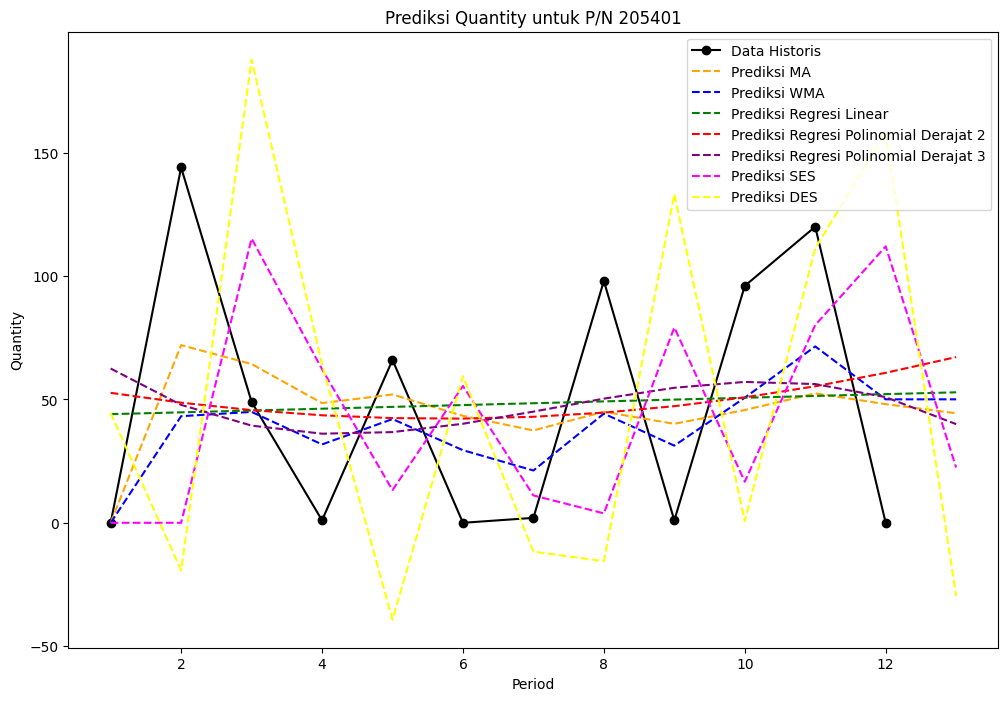

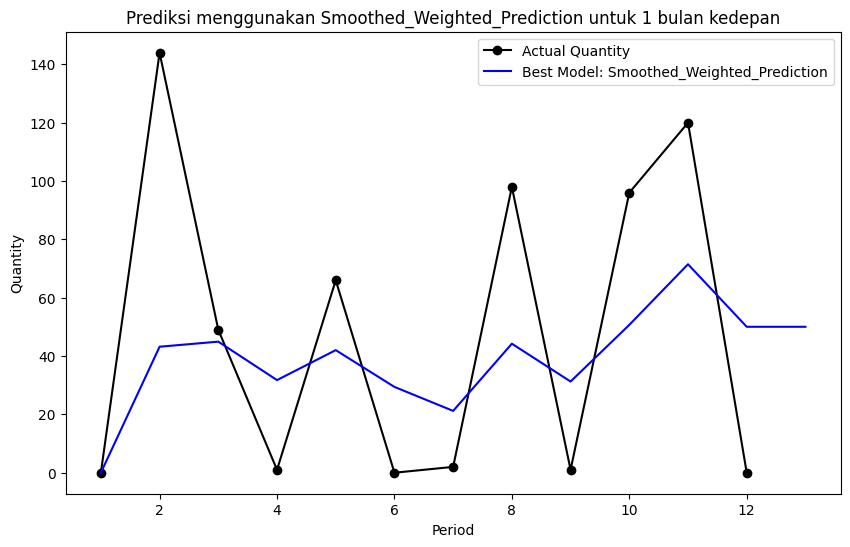

In [5]:
#PACKAGES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

# DATA
file_path = 'data.xlsx' # <- PILIH DATA DISINI
data = pd.read_excel(file_path)
def process_pn(data, pn_to_filter):
    filtered_data = data[data['P/N'] == pn_to_filter]
    formatted_data = []
    for index, row in filtered_data.iterrows():
        reversed_quantities = [row[f'D-{i}'] for i in range(1, 13)][::-1]
        for i, quantity in enumerate(reversed_quantities, start=1):
            formatted_data.append({
                'P/N': row['P/N'],
                'Period': i,
                'Quantity': quantity
            })

    formatted_df = pd.DataFrame(formatted_data)

    return formatted_df


# PILIH PN DISINI
pn_to_filter = 205401  # <--- nih yang ini (APABILA MEMILIKI HURUF PAKAI '...')
formatted_df = process_pn(data, pn_to_filter)

# MOVING AVERAGE
last_12_sum = formatted_df['Quantity'].iloc[:12].sum()
formatted_df['MA_Prediction'] = np.nan
for i in range(1, 13):
    formatted_df.loc[formatted_df['Period'] == i, 'MA_Prediction'] = formatted_df['Quantity'].iloc[:i].sum() / i

ma_13th_period = last_12_sum / 13
formatted_df = pd.concat([
    formatted_df,
    pd.DataFrame({'Period': [13], 'MA_Prediction': [ma_13th_period], 'Quantity': [np.nan]})
], ignore_index=True)

# WEIGHTED MOVING AVERAGE
def calculate_exponential_weighted_moving_average(values, alpha=0.2):
    return values.ewm(alpha=alpha, adjust=False).mean()

alpha = 0.3
formatted_df['Smoothed_Weighted_Prediction'] = calculate_exponential_weighted_moving_average(
    formatted_df['Quantity'], alpha
)

# REGRESI LINEAR
valid_data = formatted_df.dropna(subset=['Quantity'])
X = valid_data[['Period']]
y = valid_data['Quantity']
model = LinearRegression()
model.fit(X, y)
formatted_df['Linear_Regression_Prediction'] = model.predict(formatted_df[['Period']])

# POLINOM DERAJAT 2
degree = 2
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)
X_all_poly = poly.transform(formatted_df[['Period']])
formatted_df['Polynomial_Regression_Prediction_Degree_2'] = poly_model.predict(X_all_poly)

# POLINOM DERAJAT 3
degree = 3
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)
X_all_poly = poly.transform(formatted_df[['Period']])
formatted_df['Polynomial_Regression_Prediction_Degree_3'] = poly_model.predict(X_all_poly)

# SINGLE EXPONENTIAL SMOOTHING
alpha_ses = 0.8  # ubah nilai alpha (semakin besar semakin berat ke data terbaru)
beta_des = 0.8   # ubah nilai beta (semakin besar semakin cepat beradaptasi, kalo rendah bisa terjadi lag)
def apply_ses(values, alpha=alpha_ses):
    ses_model = SimpleExpSmoothing(values).fit(smoothing_level=alpha, optimized=False)
    return ses_model.fittedvalues

# DOUBLE EXPONENTIAL SMOOTHING
def apply_des(values, alpha=alpha_ses, beta=beta_des):
    des_model = ExponentialSmoothing(values, trend='add', seasonal=None).fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)
    return des_model.fittedvalues

formatted_df['SES_Prediction'] = apply_ses(formatted_df['Quantity'], alpha=alpha_ses)
formatted_df['DES_Prediction'] = apply_des(formatted_df['Quantity'], alpha=alpha_ses, beta=beta_des)

print(formatted_df)

# RMSE DAN R2
results = []
for column in ['MA_Prediction', 'Smoothed_Weighted_Prediction', 'Linear_Regression_Prediction', 'Polynomial_Regression_Prediction_Degree_2', 'Polynomial_Regression_Prediction_Degree_3', 'SES_Prediction', 'DES_Prediction']:
    valid_data = formatted_df.dropna(subset=['Quantity', column])
    if valid_data.empty:
        print(f"Skipping {column} due to lack of valid data.")
        continue
    try:
        rmse = np.sqrt(mean_squared_error(valid_data['Quantity'], valid_data[column]))
        r2 = r2_score(valid_data['Quantity'], valid_data[column])
        results.append({'Model': column, 'RMSE': rmse, 'R2': r2})
    except Exception as e:
        print(f"Error evaluating {column}: {e}")

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='R2', ascending=False).to_string(index=False))

# BEST R2
best_model_row = results_df.loc[results_df['R2'].idxmax()]
best_model_name = best_model_row['Model']
best_model_r2 = best_model_row['R2']
next_period_prediction = formatted_df.loc[formatted_df['Period'] == 13, best_model_name].values[0]

print(f"Best Model: {best_model_name}")
print(f"Best R-squared: {best_model_r2}")
print(f"Prediction for 13th Period: {next_period_prediction}")

#PLOT SEMUA GRAFIK
plt.figure(figsize=(12, 8))
plt.plot(formatted_df['Period'], formatted_df['Quantity'], label='Data Historis', marker='o', color='black')
plt.plot(formatted_df['Period'], formatted_df['MA_Prediction'], label='Prediksi MA', linestyle='--', color='orange')
plt.plot(formatted_df['Period'], formatted_df['Smoothed_Weighted_Prediction'], label='Prediksi WMA', linestyle='--', color='blue')
plt.plot(formatted_df['Period'], formatted_df['Linear_Regression_Prediction'], label='Prediksi Regresi Linear', linestyle='--', color='green')
plt.plot(formatted_df['Period'], formatted_df['Polynomial_Regression_Prediction_Degree_2'], label='Prediksi Regresi Polinomial Derajat 2', linestyle='--', color='red')
plt.plot(formatted_df['Period'], formatted_df['Polynomial_Regression_Prediction_Degree_3'], label='Prediksi Regresi Polinomial Derajat 3', linestyle='--', color='purple' )
plt.plot(formatted_df['Period'], formatted_df['SES_Prediction'], label='Prediksi SES', linestyle='--', color='magenta' )
plt.plot(formatted_df['Period'], formatted_df['DES_Prediction'], label='Prediksi DES', linestyle='--', color='yellow' )
plt.xlabel('Period')
plt.ylabel('Quantity')
plt.title(f'Prediksi Quantity untuk P/N {pn_to_filter}')
plt.legend()
plt.grid(False)
plt.show()

# PLOT GRAFIK PALING BAGUS
plt.figure(figsize=(10, 6))
plt.plot(formatted_df['Period'], formatted_df['Quantity'], label='Actual Quantity', marker='o', color='black')
plt.plot(formatted_df['Period'], formatted_df[best_model_name], label=f'Best Model: {best_model_name}', linestyle='-', color='blue')
plt.xlabel('Period')
plt.ylabel('Quantity')
plt.title(f'Prediksi menggunakan {best_model_name} untuk 1 bulan kedepan')
plt.legend()
plt.grid(False)
plt.show()


# New Section

# New Section